In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler 

In [16]:
NVDA_prices = pd.read_csv('NVDA.csv', sep=',', index_col='Date').fillna(0)

In [ ]:
# Why use LSTM:
# the stock market's movement is best captured by underlying historical trends that are better noticed by neural network models
# than human analyst observation. The LSTM neural network has 3 component gates: the input gate, forget gate and output gate.
# Of these three, the most important gates are the forget and output gates. The forget gate acts as the network's decider in 
# choosing what historical trends are useful to retain in the model's prediction of the forecasted stock prices, doing so by 
# deliberately 'forgetting' unimportant information, removing this from the model's consideration. The output gate then selects
# the information and presents the final prediction. This is due to the LSTM's feedback connection helping the model remember 
# only the relevant historical trends, and is main area that LSTM differs from a standard feed-forward network.
# The LSTM's effectiveness and model accuracy in stock price prediction has been documented in numerous academic articles.

In [17]:
tf.random.set_seed(28)

Text(0, 0.5, 'Closing Price/$')

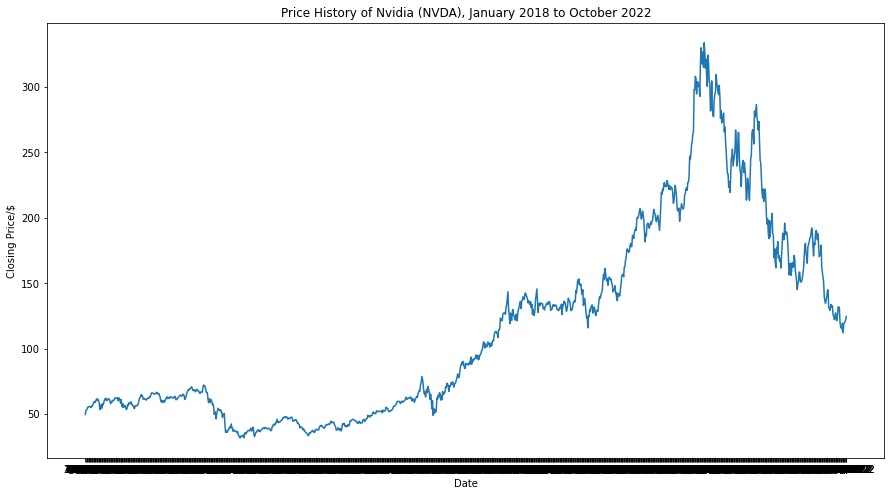

In [18]:
# data visualisation
plt.figure(figsize=(15, 8))
plt.title('Price History of Nvidia (NVDA), January 2018 to October 2022')
plt.plot(NVDA_prices ['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price/$')

In [19]:
# training dataset:
import math

closing_prices = NVDA_prices['Close']
values = closing_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
# test dataset:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# simple LSTM network:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [22]:
# model training uses mean squared error loss. Model is trained for 40 epochs:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs = 40)

Epoch 1/40
909/909 [==============================] - 21s 19ms/step - loss: 0.0011
Epoch 2/40
909/909 [==============================] - 17s 18ms/step - loss: 6.0942e-04
Epoch 3/40
909/909 [==============================] - 17s 19ms/step - loss: 4.6731e-04
Epoch 4/40
909/909 [==============================] - 17s 19ms/step - loss: 3.8864e-04
Epoch 5/40
909/909 [==============================] - 17s 19ms/step - loss: 4.4156e-04
Epoch 6/40
909/909 [==============================] - 18s 20ms/step - loss: 3.0723e-04
Epoch 7/40
909/909 [==============================] - 17s 19ms/step - loss: 2.3419e-04
Epoch 8/40
909/909 [==============================] - 18s 19ms/step - loss: 4.0560e-04
Epoch 9/40
909/909 [==============================] - 17s 19ms/step - loss: 3.4688e-04
Epoch 10/40
909/909 [==============================] - 17s 18ms/step - loss: 4.0646e-04
Epoch 11/40
909/909 [==============================] - 18s 19ms/step - loss: 2.7407e-04
Epoch 12/40
909/909 [========================

In [23]:
# root mean square error for evaluation on held-out training set:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 16ms/step


5.325747442078143

C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\3400610123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


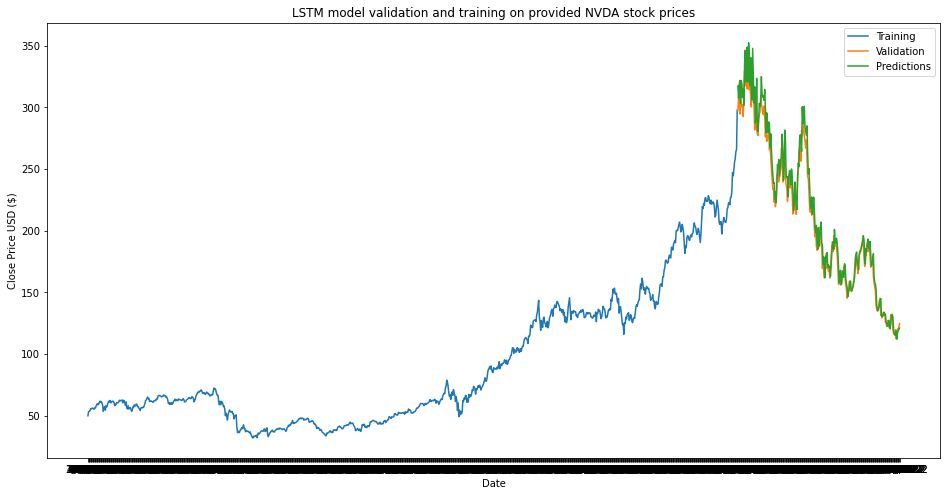

In [24]:
# data visualisation of the model's training.
data = NVDA_prices.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM model validation and training on provided NVDA stock prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='upper right')
plt.show()

In [ ]:
# choosing lookback window for forecast window of [2 weeks -> 10 trading days] 10 values (24-10 to 4-11)
# NVDA is a closely watched stock with major market reactions to news on its business model and health occuring, on average,
# once every 6 weeks. Hence, a 12 week lookback window might be appropriate to help the model forecast the 24-10 to 4-11 stock 
# prices over two news cycles.

In [39]:
lookback = 60
forecast = 10

y = NVDA_prices['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [40]:
x_predict = []
y_predict = []

In [41]:
for i in range(lookback, len(y) - forecast + 1):
    x_predict.append(y[i - lookback: i])
    y_predict.append(y[i: i + forecast])

X = np.array(x_predict)
Y = np.array(y_predict)

In [42]:
# same model, now with restricted window
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape= (lookback, 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(Dense(forecast))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 122,210
Trainable params: 122,210
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, Y, batch_size= 1, epochs = 40)

Epoch 1/40
1142/1142 [==============================] - 35s 27ms/step - loss: 0.0055
Epoch 2/40
1142/1142 [==============================] - 32s 28ms/step - loss: 0.0029
Epoch 3/40
1142/1142 [==============================] - 34s 29ms/step - loss: 0.0023
Epoch 4/40
1142/1142 [==============================] - 34s 30ms/step - loss: 0.0021
Epoch 5/40
1142/1142 [==============================] - 34s 30ms/step - loss: 0.0018
Epoch 6/40
1142/1142 [==============================] - 34s 30ms/step - loss: 0.0018
Epoch 7/40
1142/1142 [==============================] - 31s 27ms/step - loss: 0.0018
Epoch 8/40
1142/1142 [==============================] - 28s 24ms/step - loss: 0.0018
Epoch 9/40
1142/1142 [==============================] - 32s 28ms/step - loss: 0.0017
Epoch 10/40
1142/1142 [==============================] - 33s 29ms/step - loss: 0.0016
Epoch 11/40
1142/1142 [==============================] - 33s 29ms/step - loss: 0.0017
Epoch 12/40
1142/1142 [==============================] - 33s 29

In [44]:
X_forecast = y[- lookback:]
X_forecast = X_forecast.reshape(1, lookback, 1)

Y_forecast = model.predict(X_forecast).reshape(-1, 1)
Y_forecast = scaler.inverse_transform(Y_forecast)

1/1 [==============================] - 1s 1s/step


In [45]:
X_forecast

array([[[0.4962416 ],
        [0.5054472 ],
        [0.50826183],
        [0.52041454],
        [0.53107715],
        [0.52359348],
        [0.4839895 ],
        [0.46057815],
        [0.49405608],
        [0.48892345],
        [0.51432164],
        [0.52501739],
        [0.51995095],
        [0.50193715],
        [0.51644091],
        [0.4858439 ],
        [0.45885623],
        [0.46372394],
        [0.46508161],
        [0.48796318],
        [0.43322627],
        [0.41802706],
        [0.4070002 ],
        [0.39461571],
        [0.35630316],
        [0.34670021],
        [0.3406735 ],
        [0.34891882],
        [0.35805818],
        [0.37120432],
        [0.37511176],
        [0.32961355],
        [0.32951421],
        [0.32292457],
        [0.33183216],
        [0.33792511],
        [0.33110365],
        [0.33391833],
        [0.31073876],
        [0.30924865],
        [0.2997119 ],
        [0.30583792],
        [0.31653365],
        [0.29944698],
        [0.29676478],
        [0

In [46]:
df_past = NVDA_prices[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Forecast'])
df_future['Date'] = pd.date_range(start='24/10/2022', periods=forecast)
df_future['Forecast'] = Y_forecast.flatten()

C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\57869379.py:3: UserWarning: Parsing '15/10/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_past['Date'] = pd.to_datetime(df_past['Date'])
C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\57869379.py:3: UserWarning: Parsing '16/10/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_past['Date'] = pd.to_datetime(df_past['Date'])
C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\57869379.py:3: UserWarning: Parsing '17/10/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_past['Date'] = pd.to_datetime(df_past['Date'])
C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\57869379.py:3: UserWarning: Parsing '18/10/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_past['Date'] = pd.to_datetime(df_past['Date'])


In [47]:
# predicted stock prices from 24-10 to 4-11:
# note: the dates in this forecast table are wrong.
df_future

,Date,Actual,Forecast
0,2022-10-22,NaN,124.289337
1,2022-10-23,NaN,124.689560
2,2022-10-24,NaN,125.785461
3,2022-10-25,NaN,125.194527
4,2022-10-26,NaN,126.184433
5,2022-10-27,NaN,126.835556
6,2022-10-28,NaN,126.861961
7,2022-10-29,NaN,125.921173
8,2022-10-30,NaN,127.226669
9,2022-10-31,NaN,128.656113


In [48]:
results = df_past.append(df_future).set_index('Date')

C:\Users\chuak\AppData\Local\Temp\ipykernel_74820\1673357870.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')
